In [1]:
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from functions_2 import *
import config_gen
from itertools import product
from skspatial.objects import Line,Points
import pandas as pd
import csv


#### sensor_parameters
dist_z = 8.5 # [mm] distance between planes
Lgap = 4.85 # GAP STAVE mm + addition distance for space compliance (mechanincal)
Sgap = 0.15 # GAP CHIP mm
width = 30 #width of the turrets [mm]
stavew=width+Sgap
ProbNoise = config_gen.ProbNoise
ProbMiss = config_gen.ProbMiss


Generatore di dataset:

num_samples = config_gen.N_EVGEN
num_lines_per_plot = config_gen.N_TRK
num_plots,num_gen_events = 0,0
cont = []

while (num_gen_events<=num_samples):

    point, direction = generate_random_line()   #Se volessi generare la retta da un punto specifico, devo dare in pasto una lista [x,y,z=0], un bool False --generate_random_line(point,False)
    points_on_line = get_points(direction, point,[0.,-dist_z,-2*dist_z])

    if limiti_spaziali(points_on_line):
        num_plots+=1
        for i in points_on_line.T[1]:
            if missed_stave(i, stavew, Lgap) and ( True in np.isclose(points_on_line,i) ):
                indici = np.where( np.isclose(points_on_line,i) )
                if(len(indici)==1):
                    points_on_line = np.delete(points_on_line,indici[0]*3+range(3))
                if(len(indici)>1):
                    points_on_line = np.delete(points_on_line,indici[0][0]*3+range(3))
                    points_on_line = points_on_line.reshape(-1,3)
            noise_index = np.random.uniform(0,1)
            
            if (noise_index < ProbMiss) and (len(points_on_line)>0):
                indici = np.array( np.random.randint(0,len(points_on_line)) )
                points_on_line = np.delete(points_on_line,indici*3+range(3))
            points_on_line = points_on_line.reshape(-1,3)
        cont.append( dati( num_gen_events , points_on_line , direction , point , num_plots) )
        noise = noise_gen(ProbNoise, dist_z)
        cont.append( dati(num_gen_events, noise, np.zeros_like(direction),np.zeros_like(point),-1) )

    if(num_plots==num_lines_per_plot):
        num_plots = 0
        num_gen_events+=1 #index for the plot
    
save_csv_py(cont)


Visualizzatore dati:

[1. 1. 1.]
[1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1.]
[0. 0. 0.]
[1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1.]
[1. 1.]
[1. 1. 1.]
[1. 1.]
[1. 1. 1.]
[0.]
[0. 0. 0.]
[1. 1.]


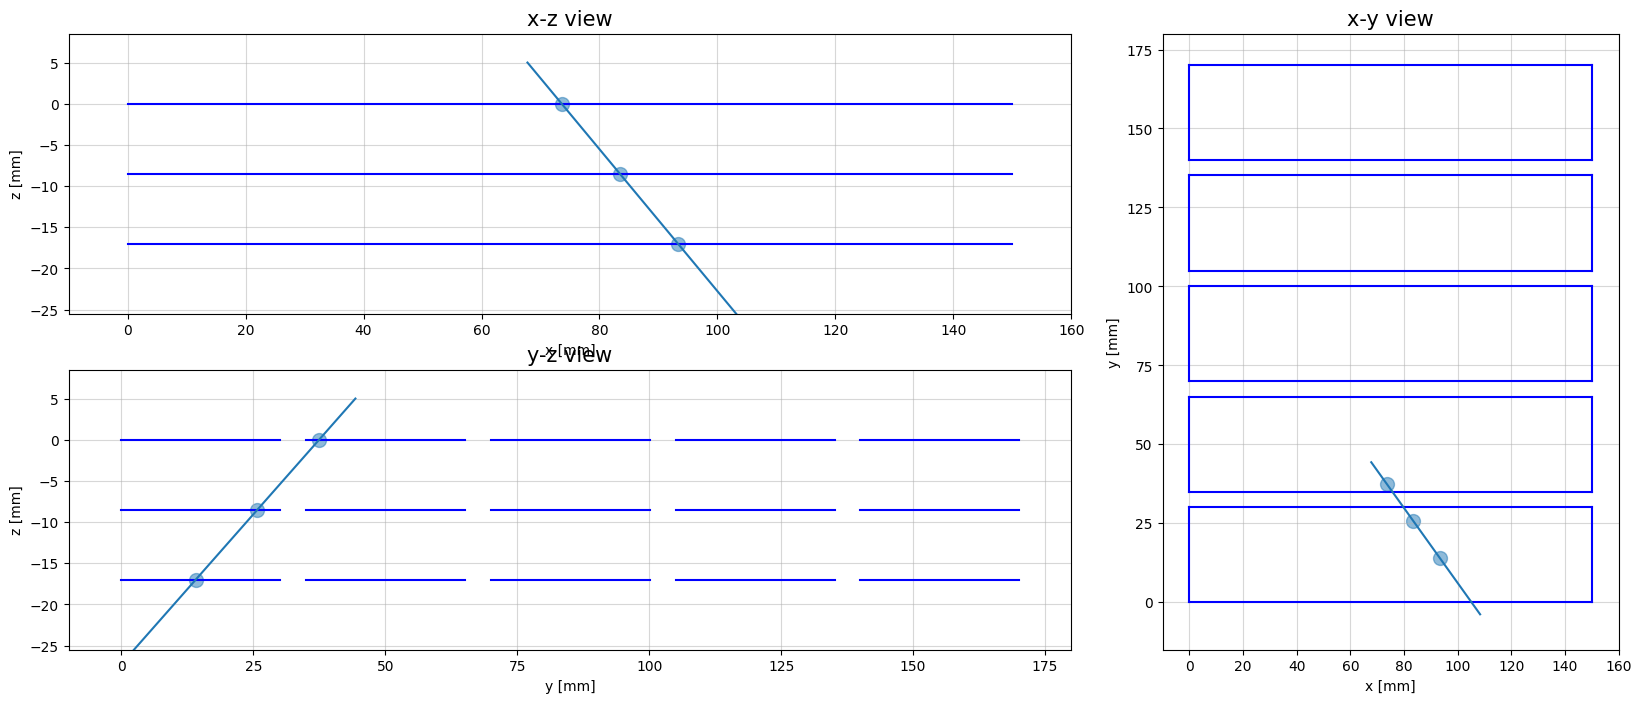

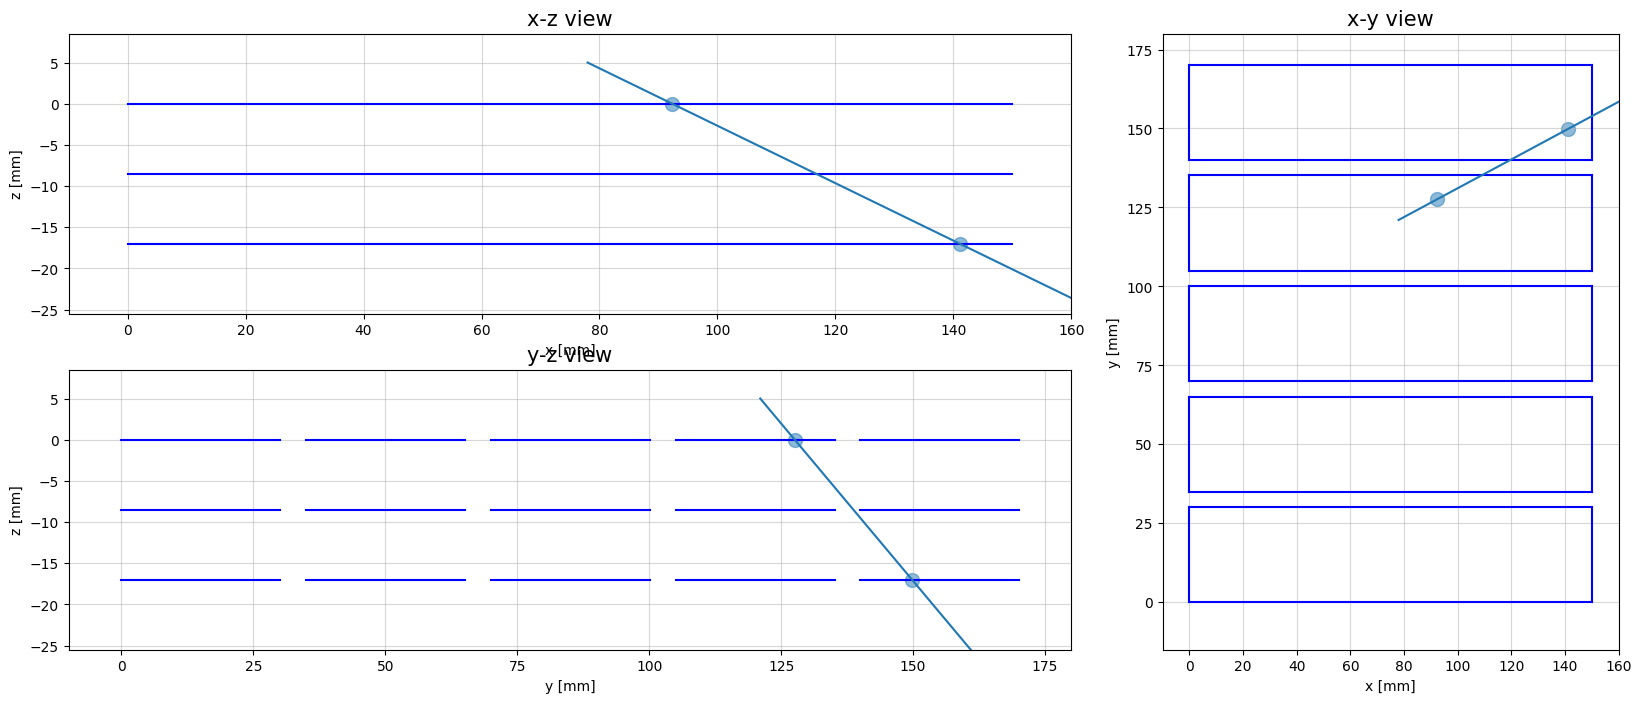

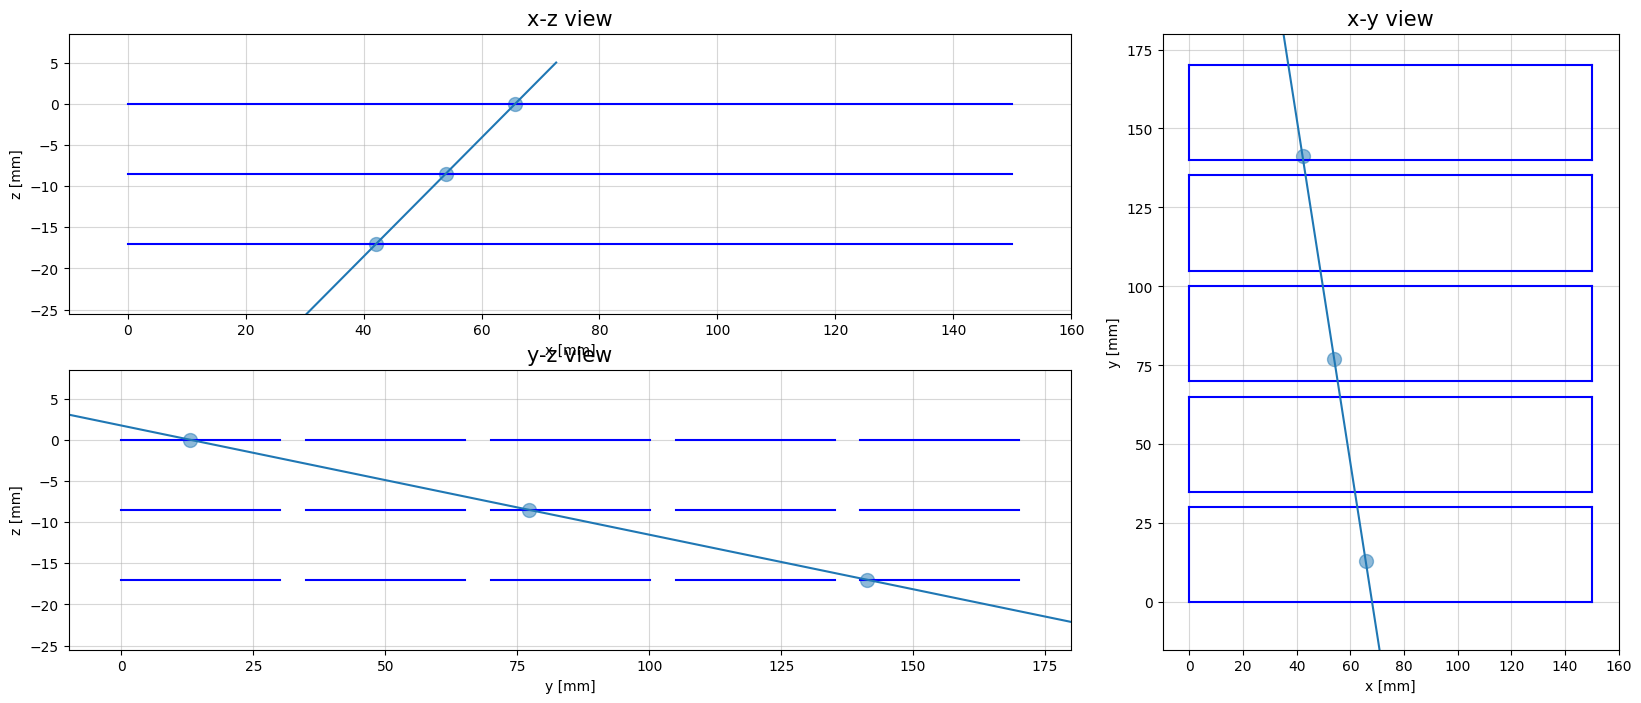

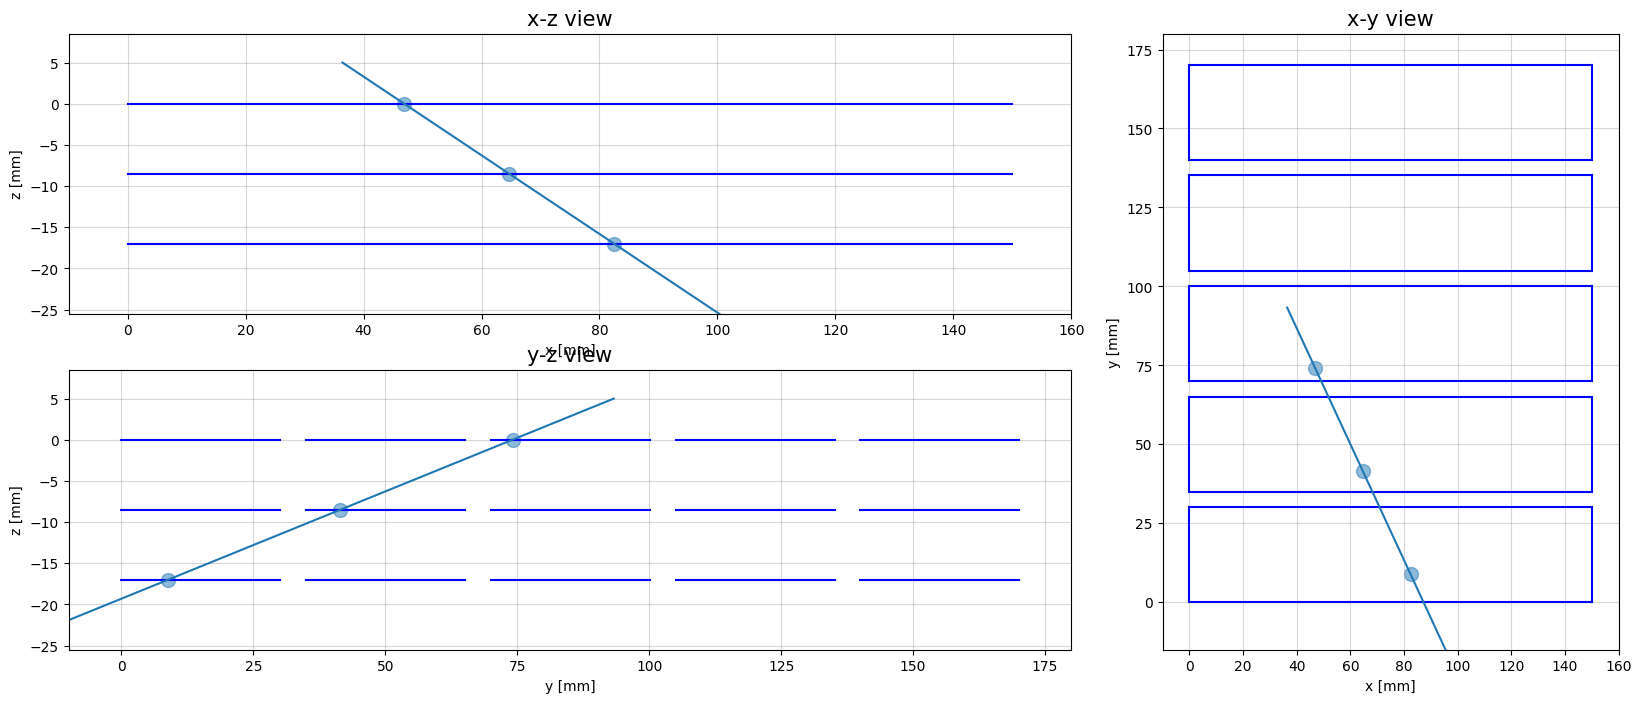

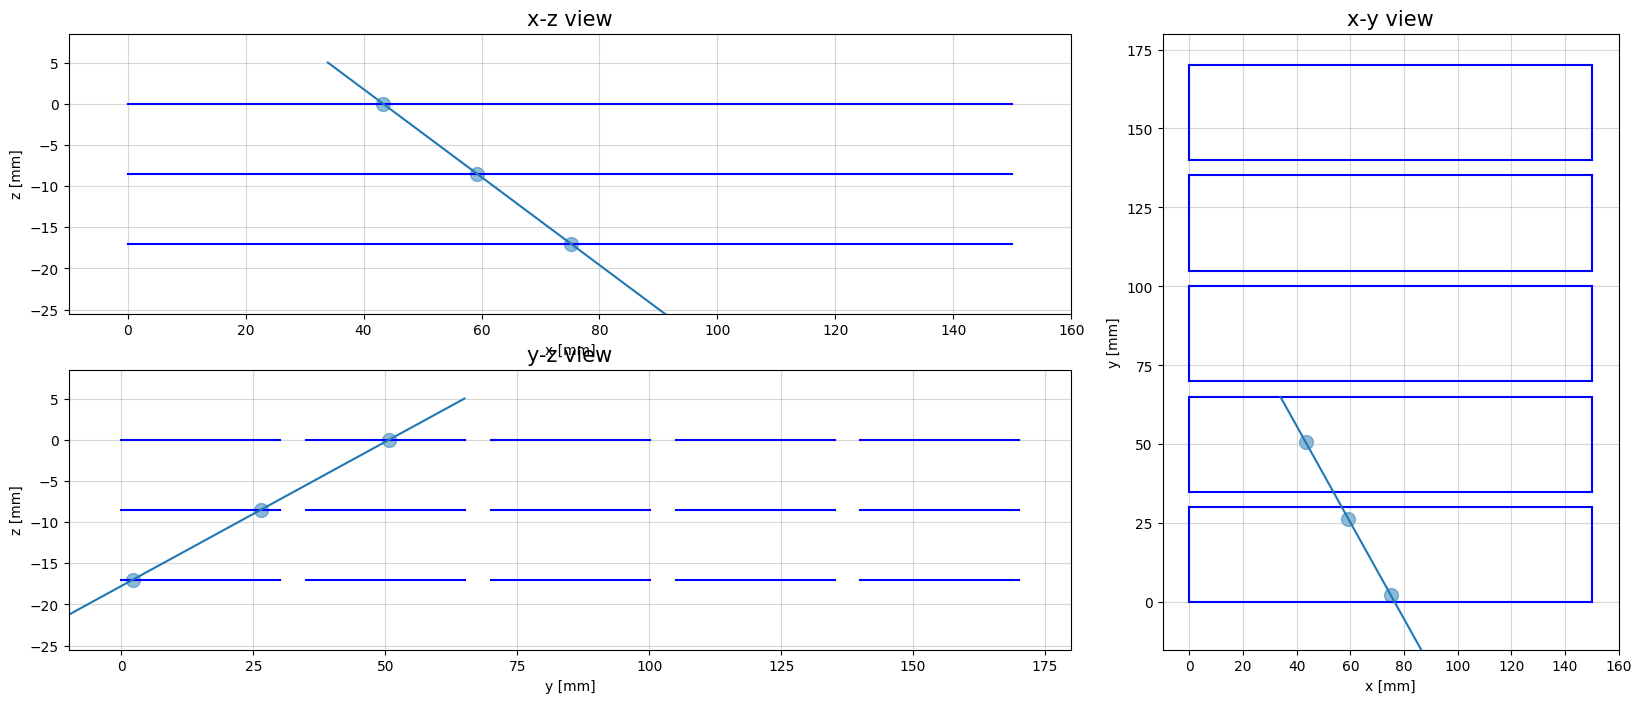

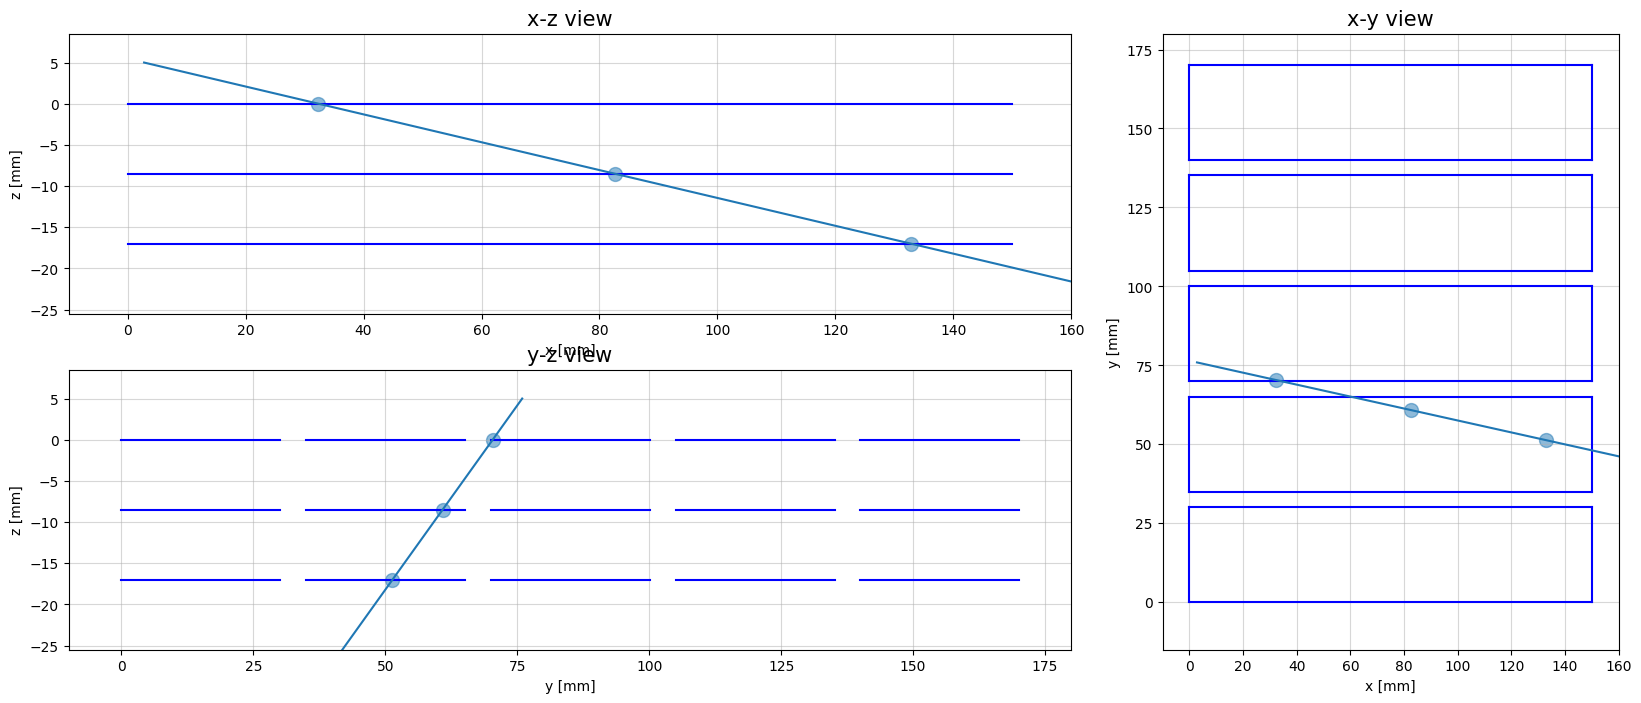

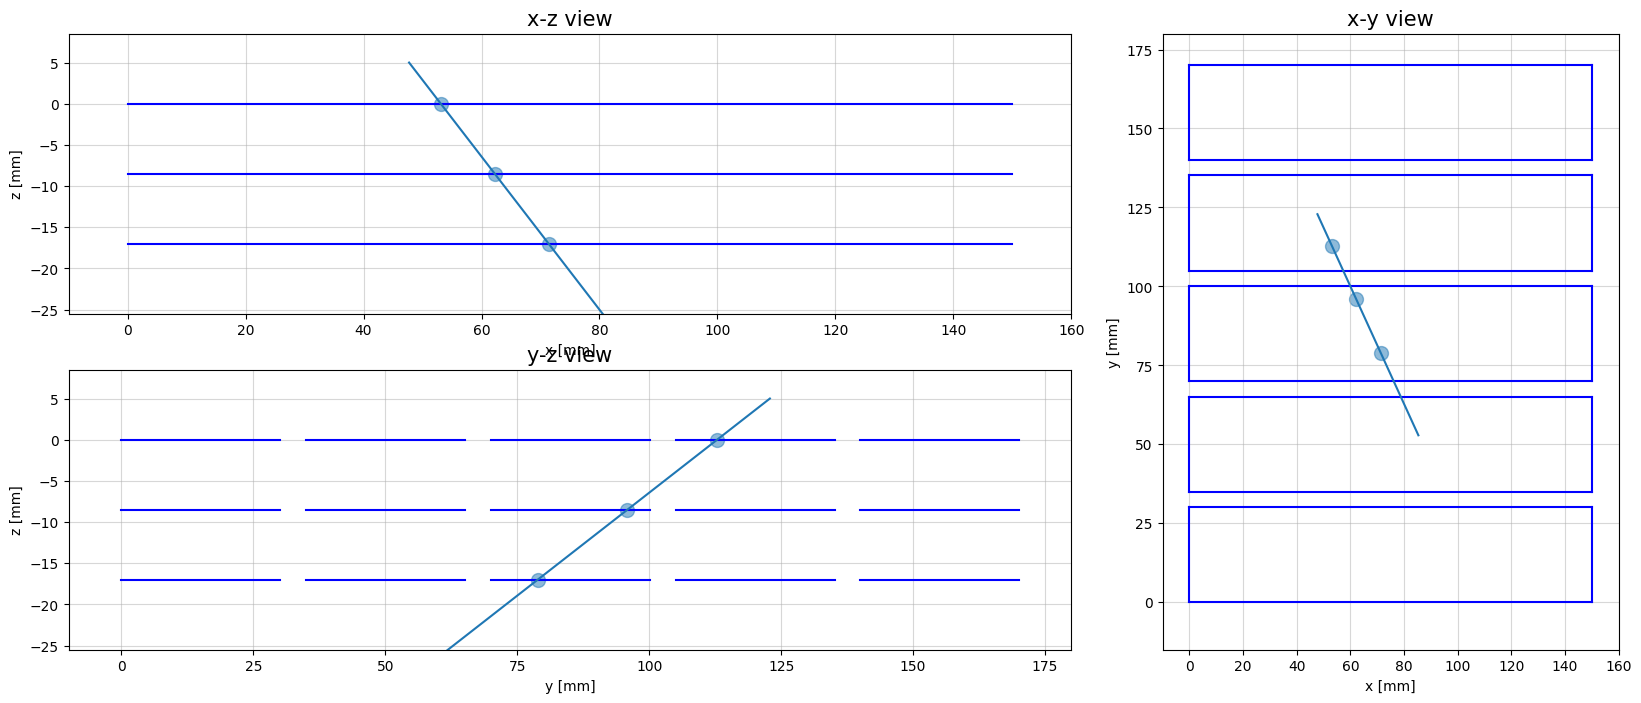

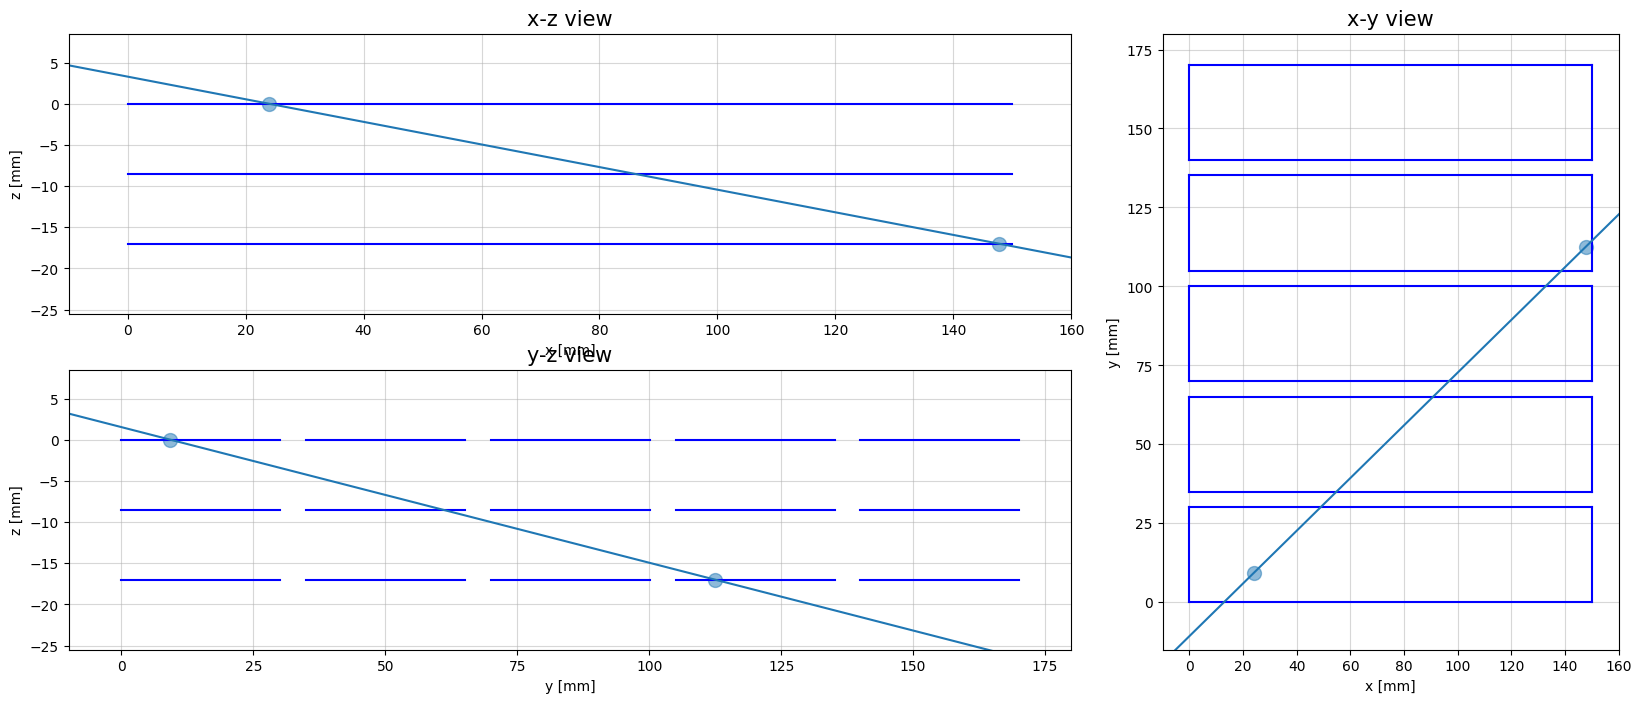

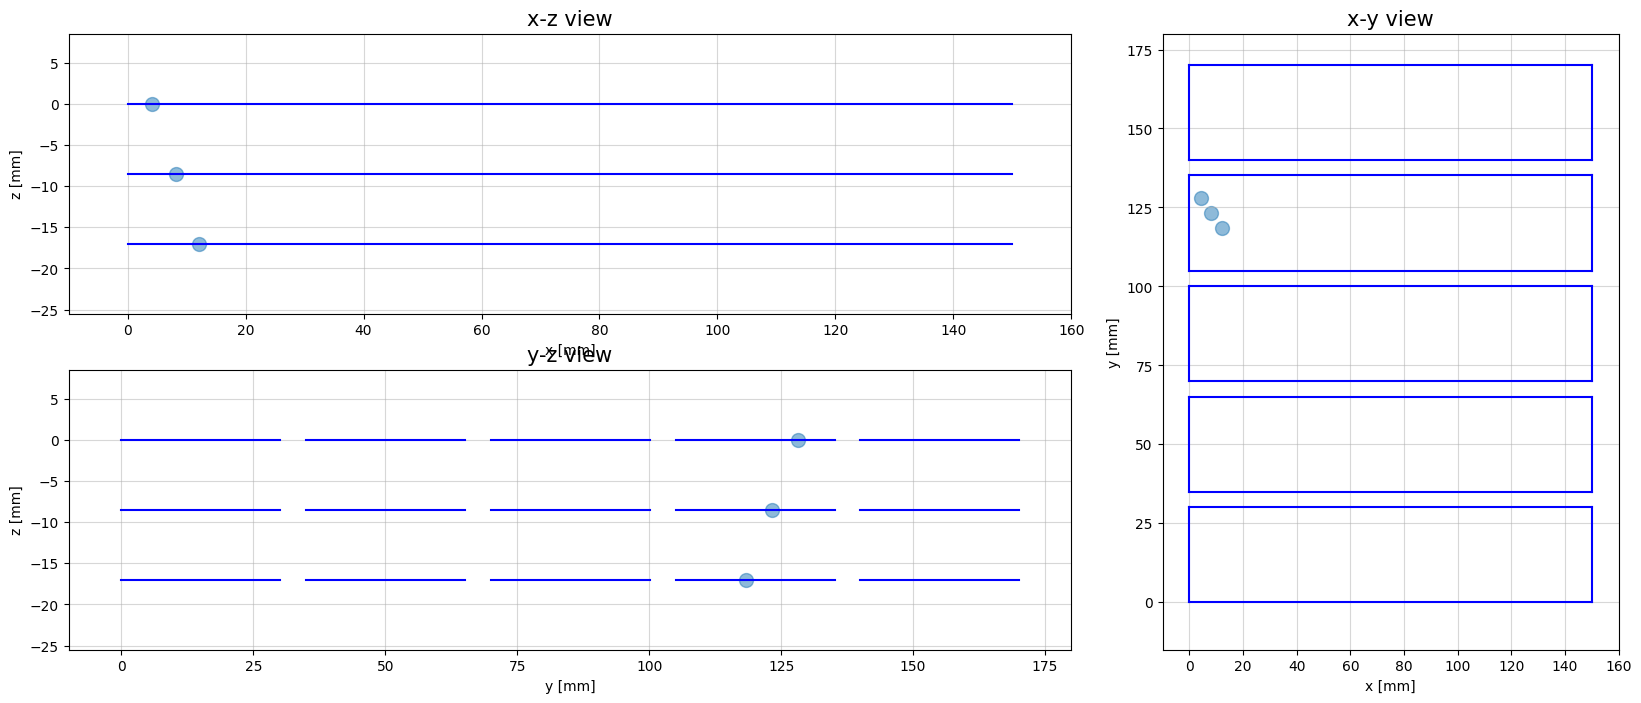

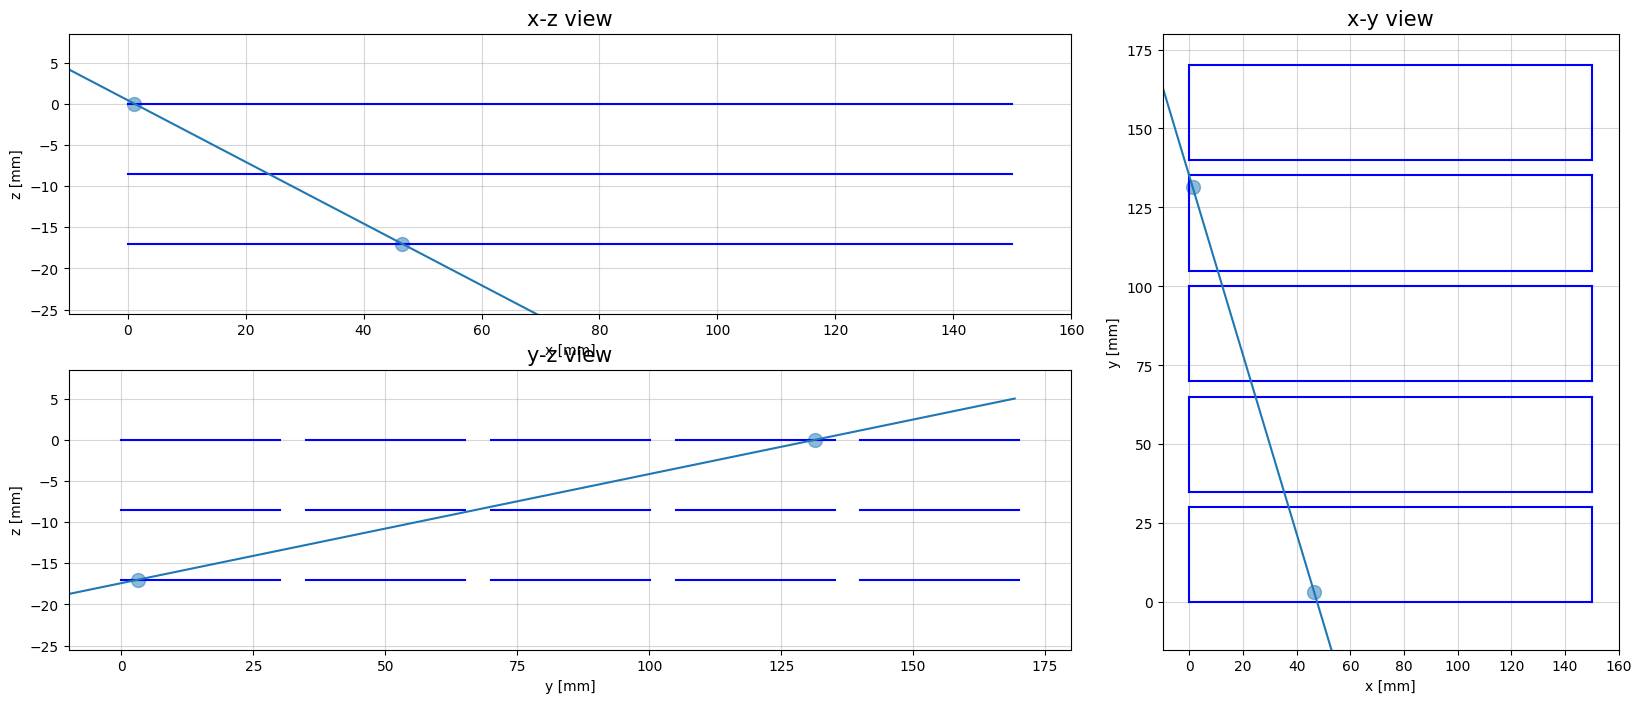

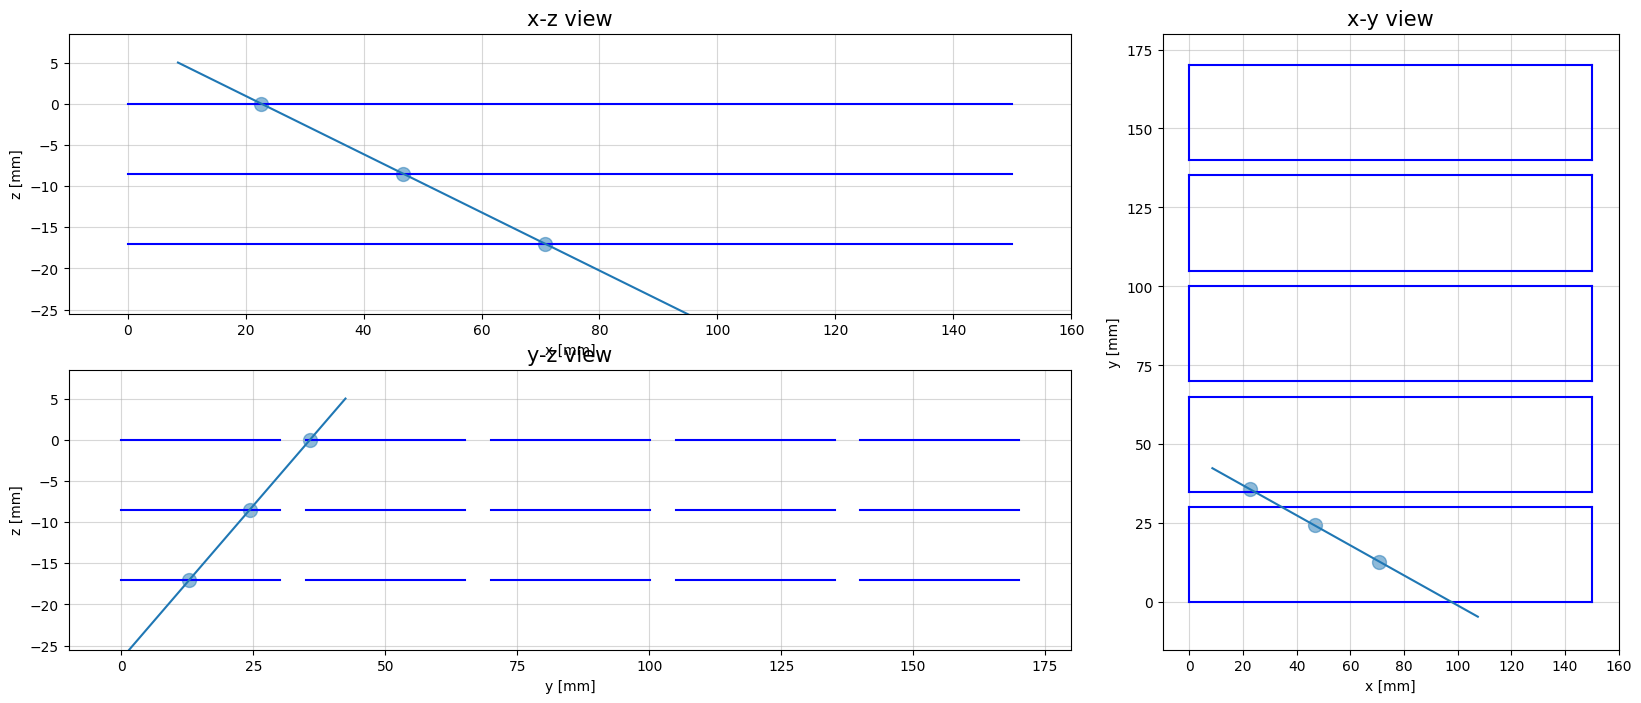

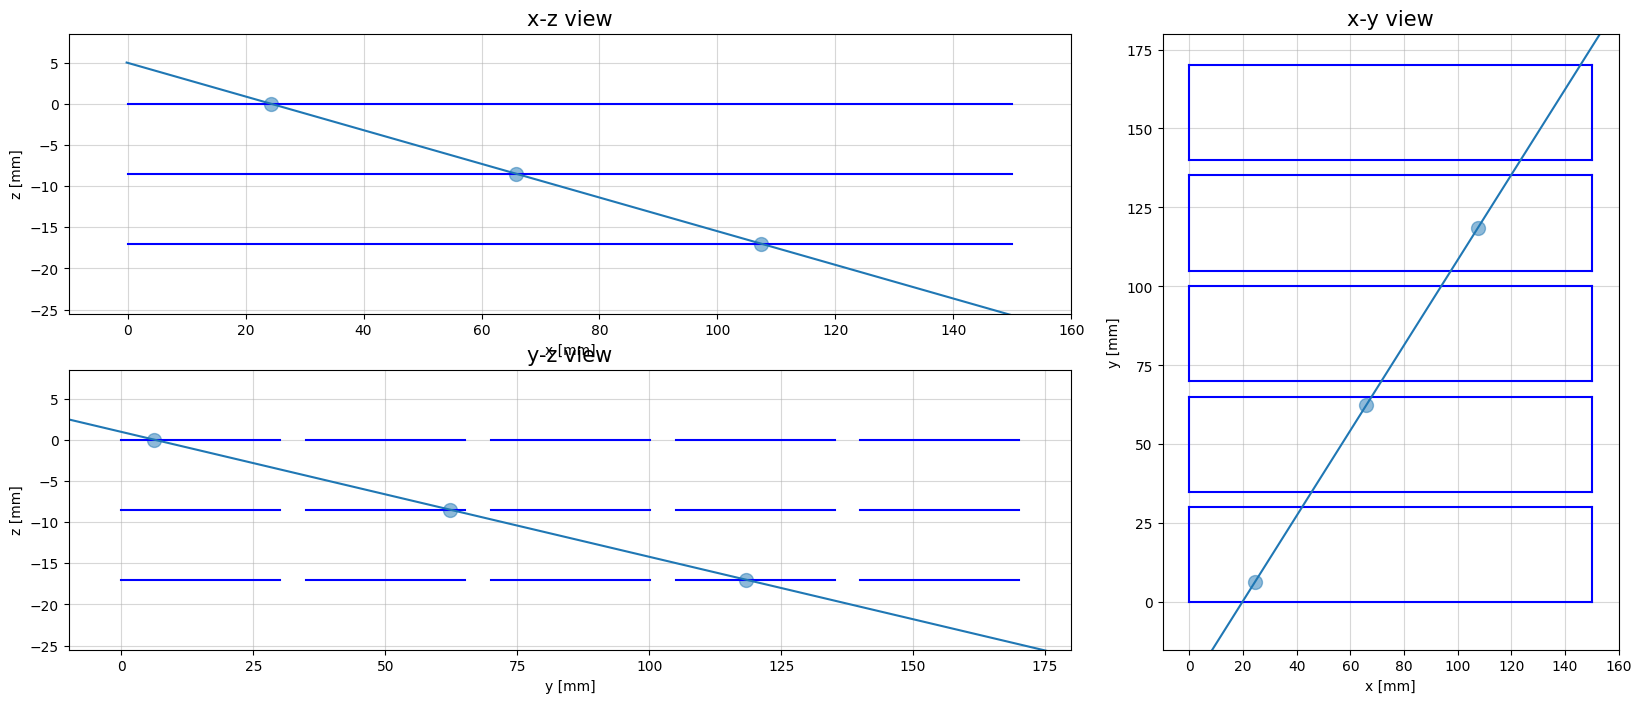

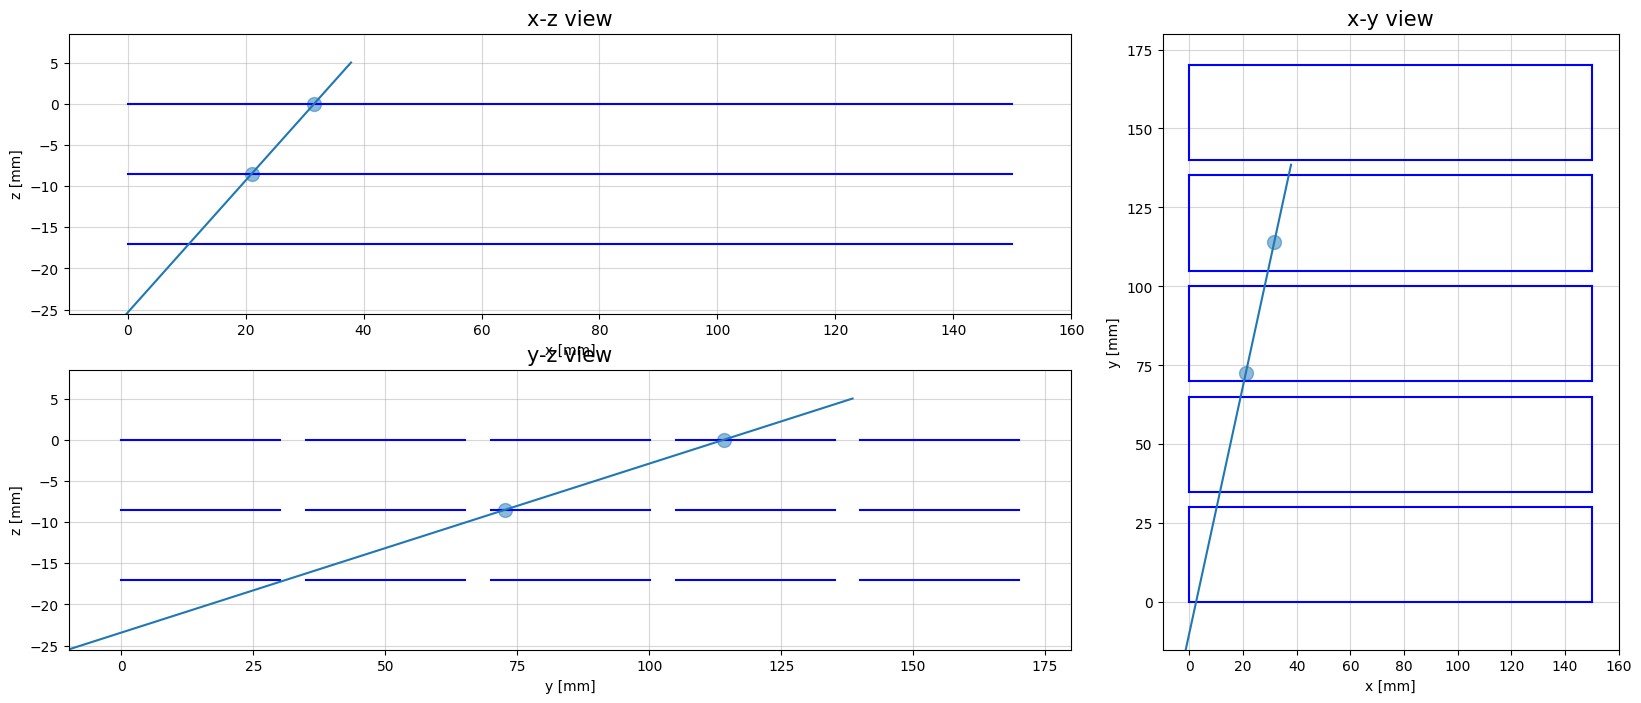

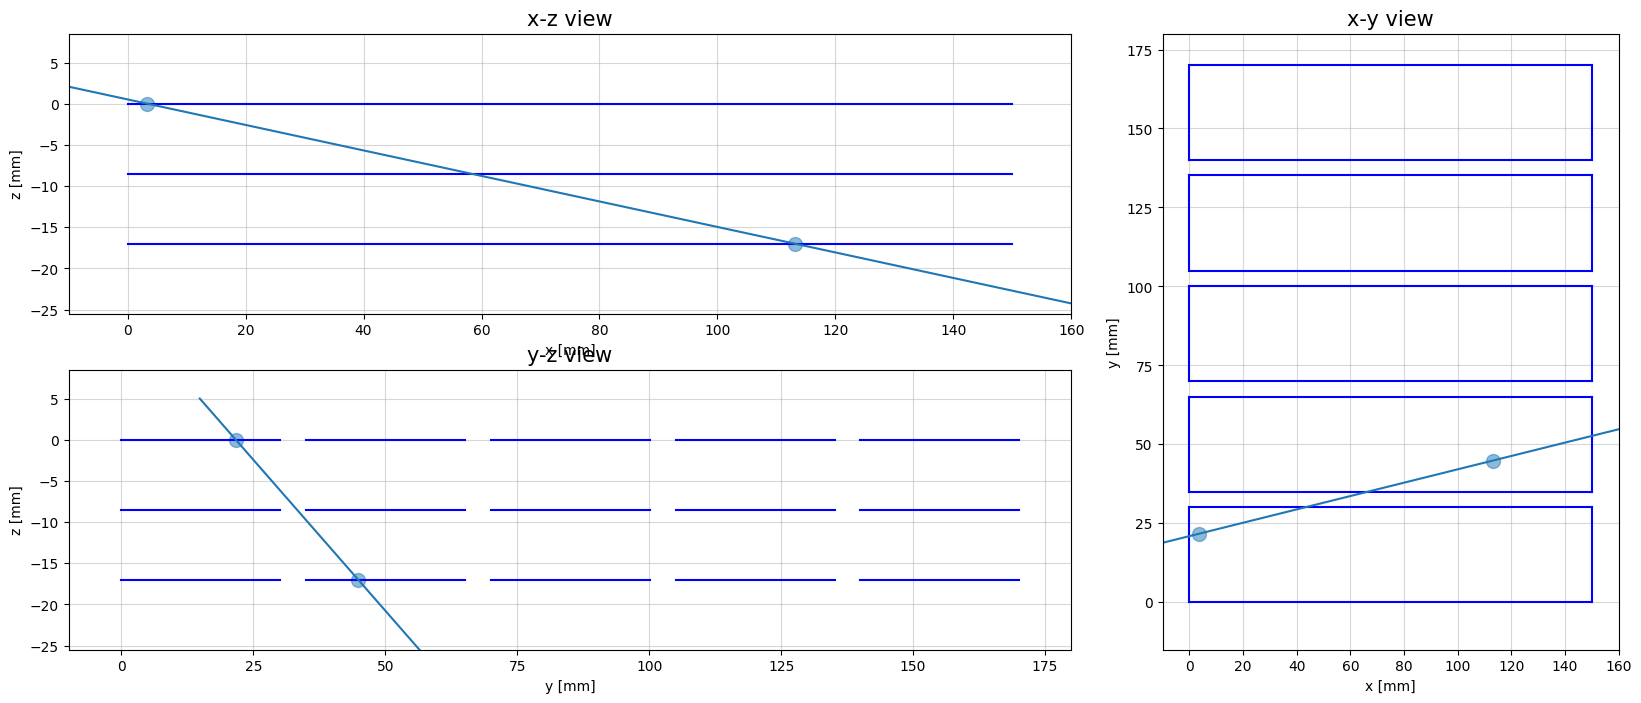

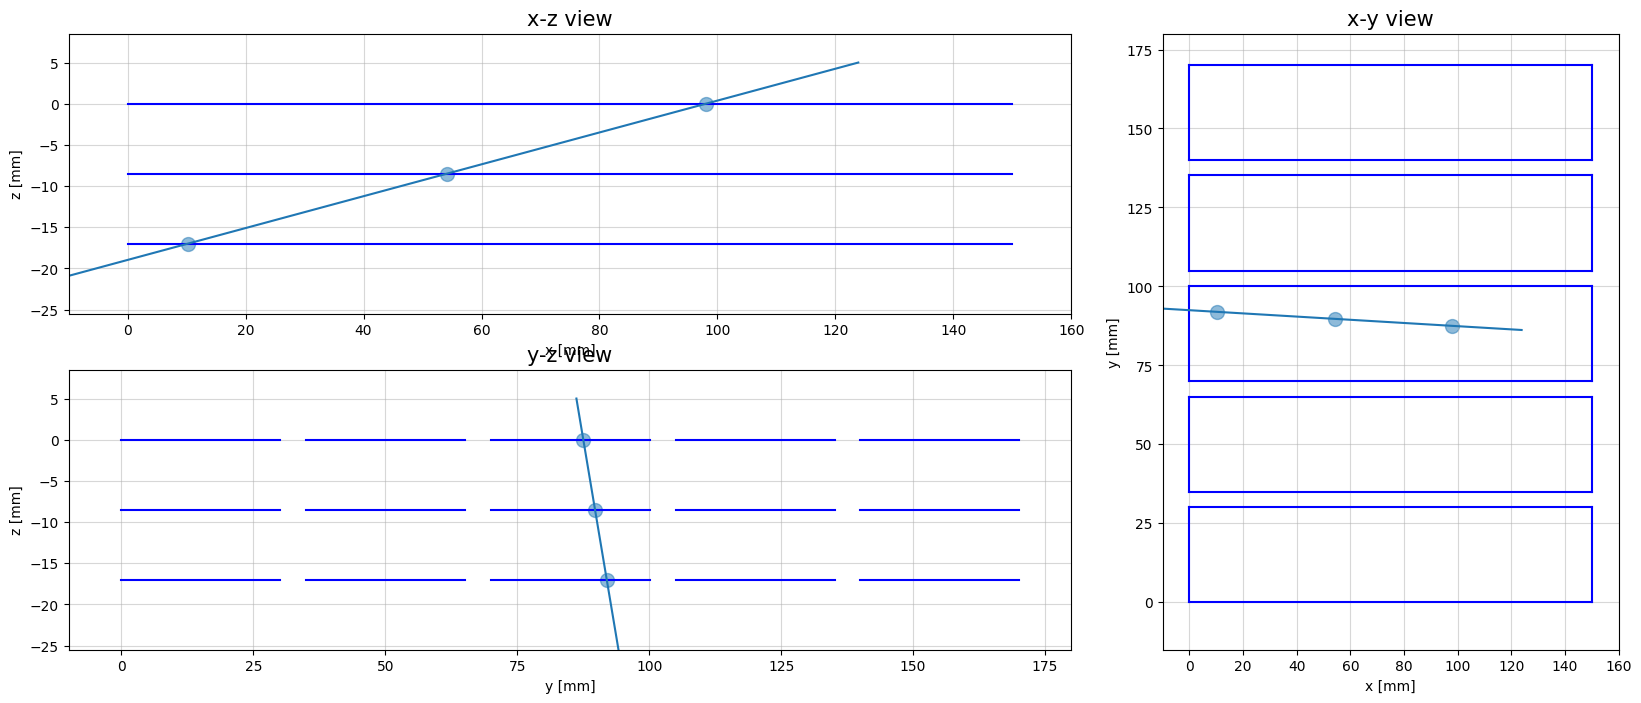

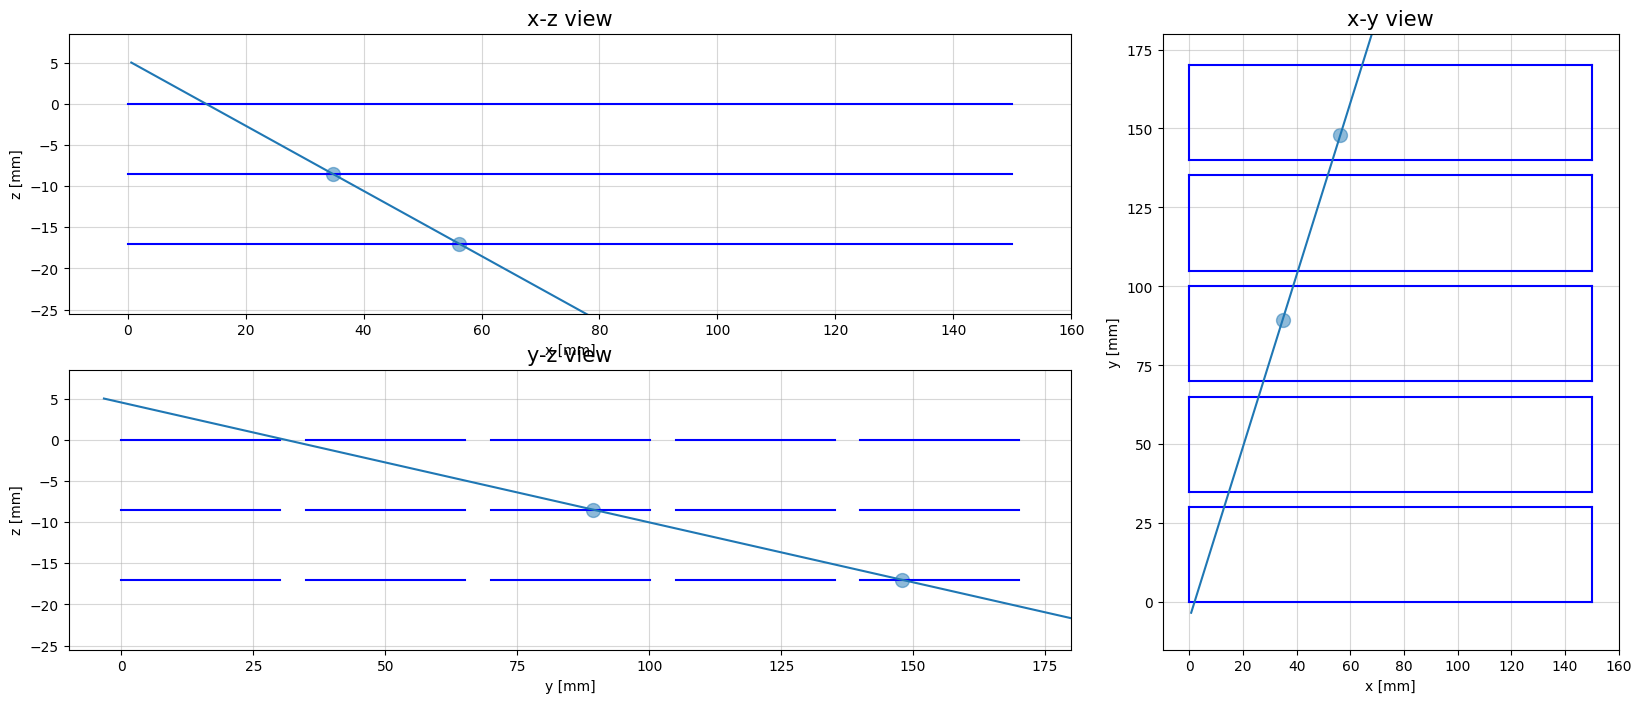

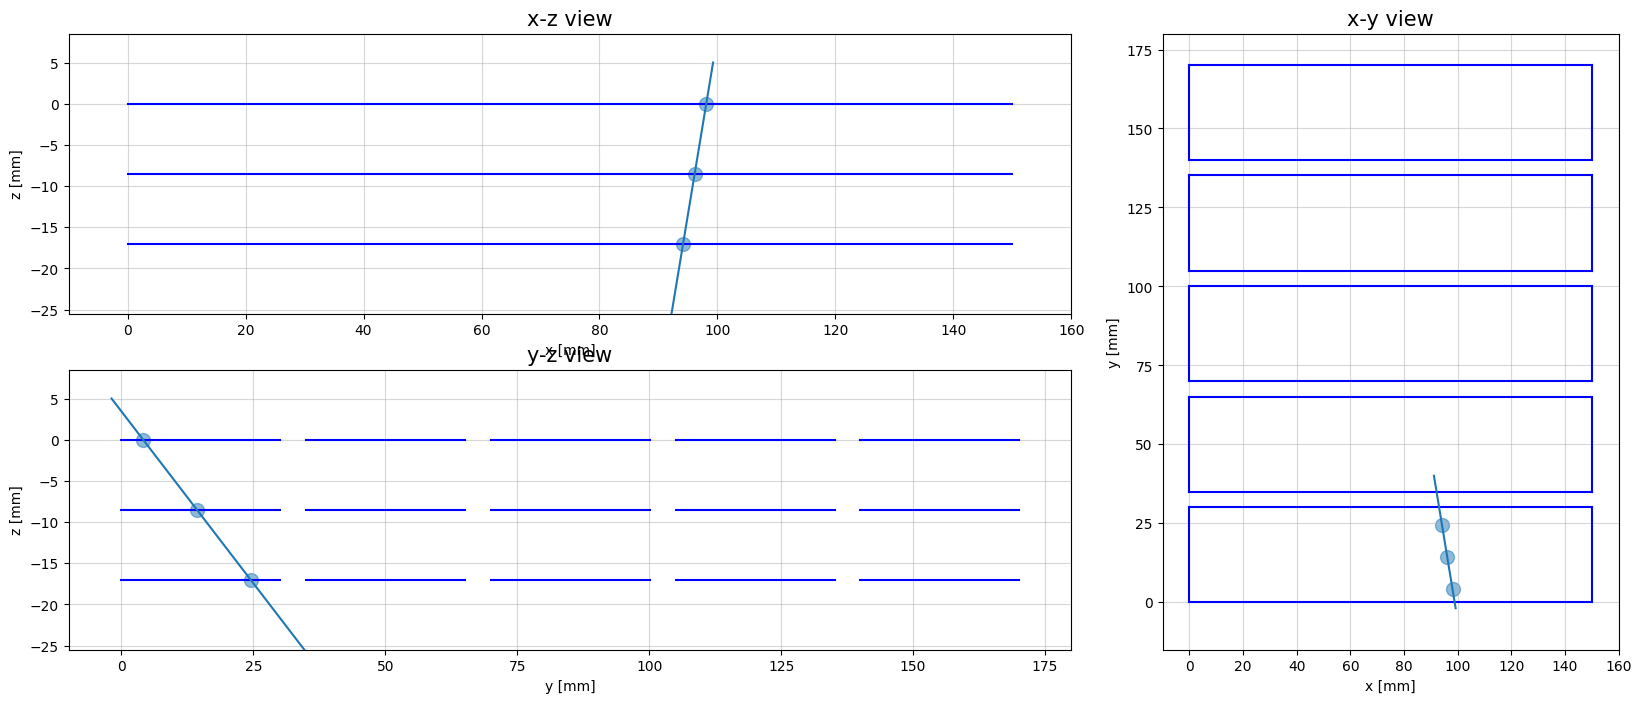

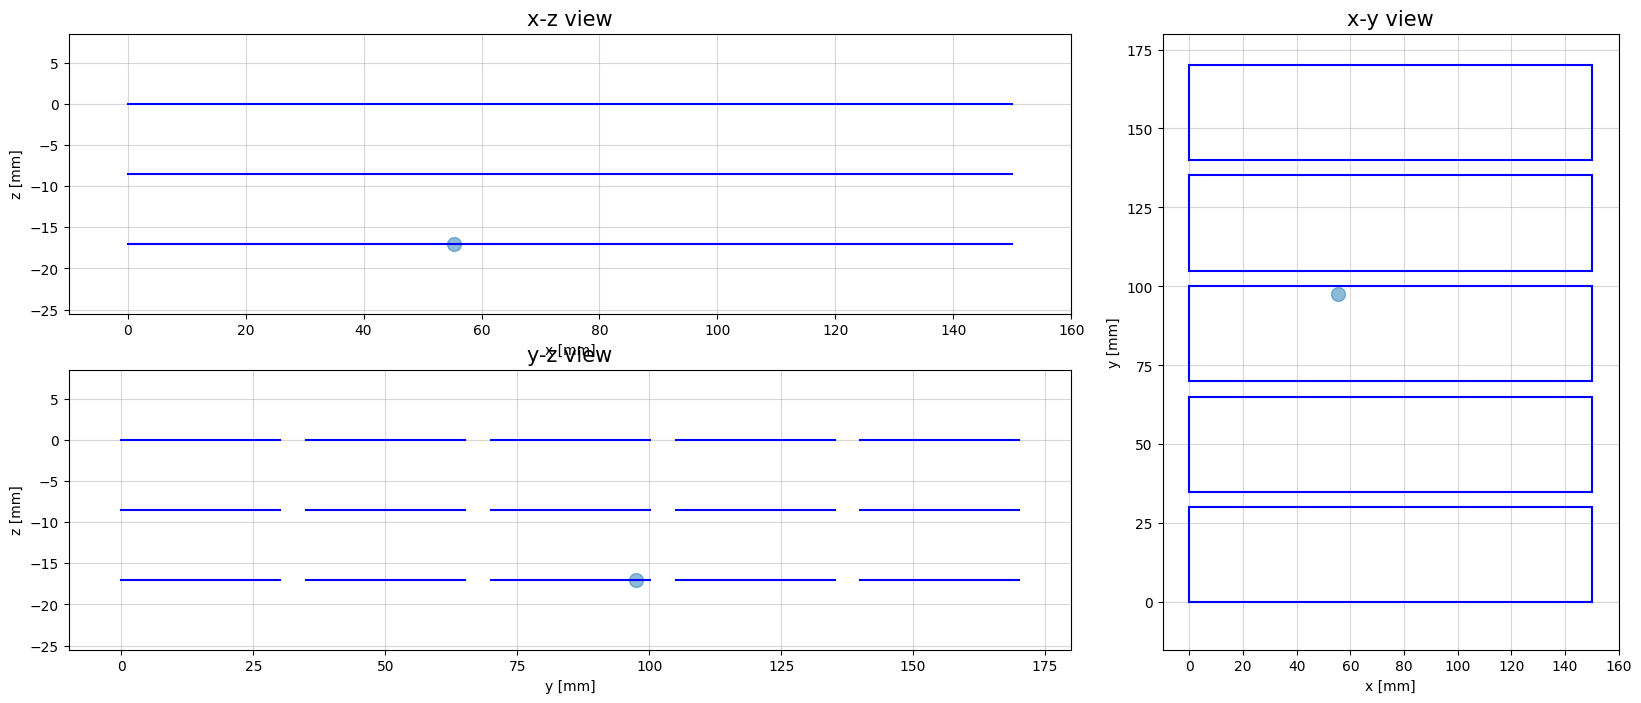

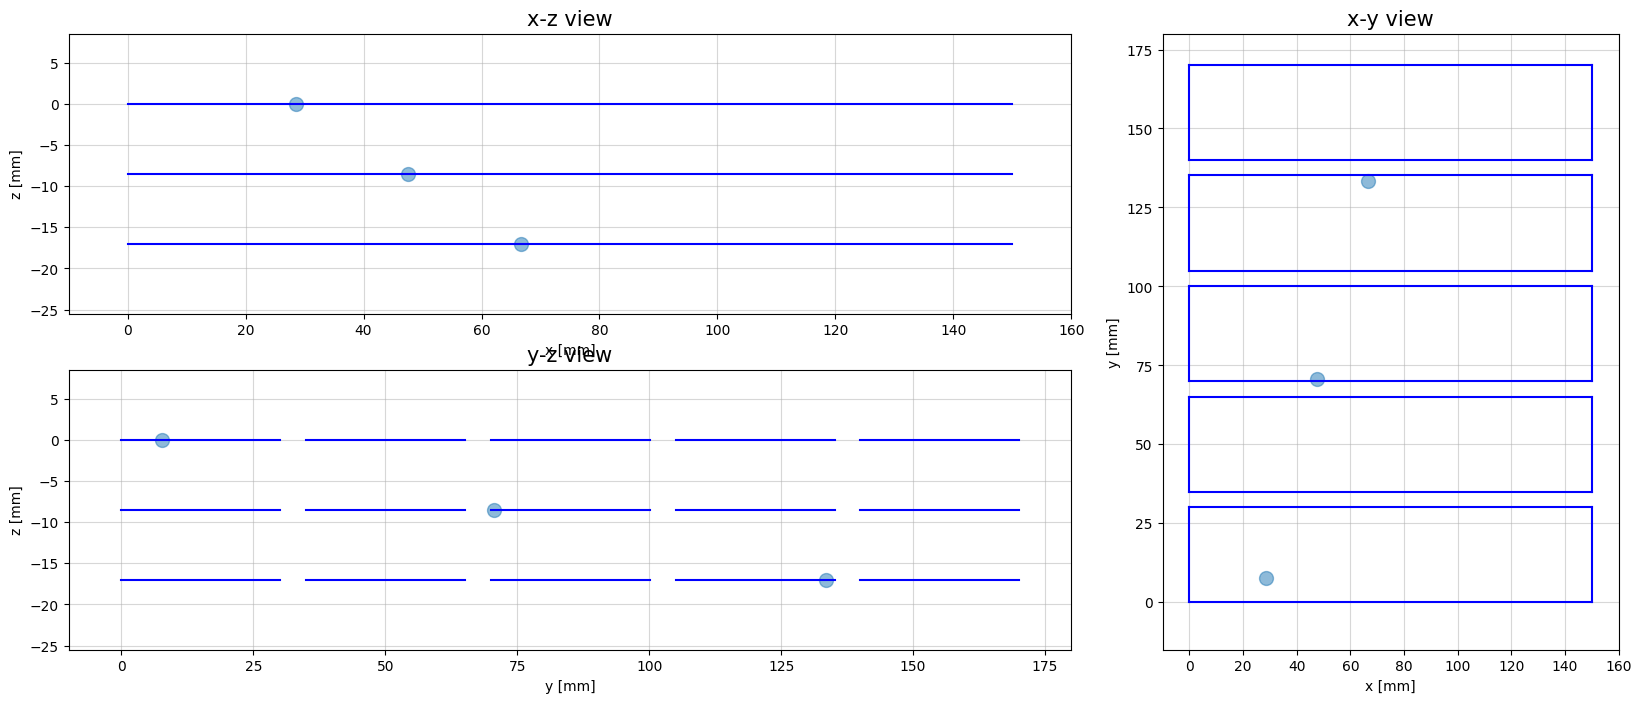

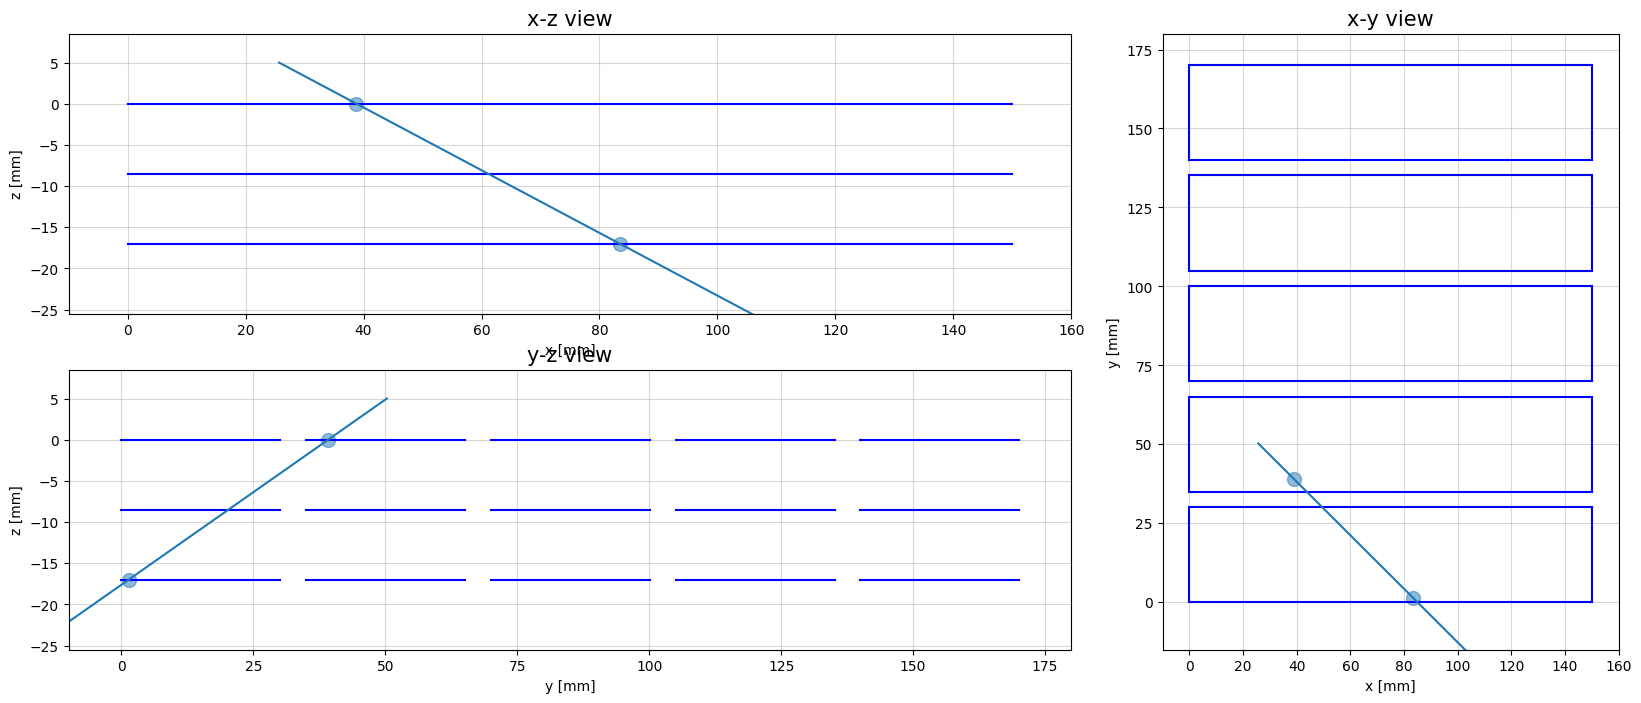

In [8]:

counter = 0
n_plot = 20
nome = '/home/luca/Uni/VI/Tesi/reconstructed_tracks_1_no_NaN.csv'
df = pd.read_csv(nome, header=None).dropna()
event = df.iloc[:, 0]
rec = df.iloc[:, 1]
direction = df.iloc[:, 2:5].values
point_on_line = df.iloc[:, 5:8].values
points_reco = df.iloc[:, 8:].values
event_values = np.unique(event)
for i in event_values[:n_plot]:
    points = []
    pol = []    
    maschera_punti = np.array([int(ev)==int(i) for ev in event])
    direction_reco = []
    for a in direction[maschera_punti].astype(float):
        # Usa np.all per confrontare array float
        if any(np.all(np.isclose(a, b)) for b in direction_reco):
            continue
        direction_reco.append(a)
    direction_reco = np.array(direction_reco)


    # mi dice quante diverse rette ho generato per l'evento i
    for j in range(len(direction_reco)):
        idx = np.where(np.all(direction[maschera_punti].astype(float) == direction_reco[j], axis=1))[0]
        points.append(points_reco[maschera_punti][idx])

    for a in point_on_line[maschera_punti].astype(float):
        if any(np.all(np.isclose(a, b)) for b in pol):
            continue
        pol.append(a)
    pol=np.array(pol)
    direction_reco = np.array(direction_reco)
    rec_id = np.array(rec[maschera_punti]).astype(float)
    if np.any(direction_reco == 0):
        seg = False
    else:
        seg = True
    
    if(is_null(len(points))):
        continue
    else:
        display_single_fit(points,direction_reco,pol,seg)
        print(rec_id)



Fitting dei dati:

1. Regressione lineare randomizzata:

    - Divido i punti in tutti i gruppi da tre (uno per livello).
    - fitto rette a questi tre punti. Considero quella a chi2 minore (sotto al chi2 soglia di 3)
    - tolgo i punti relativi alla retta a chi2 minore
    - ripeto il processo fino ad esaurimento punti
    - valuto se le tracce ricostruite sono corrette   


In [ ]:
file_list = [f'/home/luca/Uni/VI/Tesi/data/10k_{i}_tracks.csv' for i in range(1, 6)]
#file_list = ['/home/luca/Uni/VI/Tesi/data/10k_2_tracks.csv']
rec=[]
non_rec = []
from_start = []
sing = []
l=0
rec_name = [f'reconstructed_tracks_{i}_no_NaN.csv' for i in range(1, 6)]
for nome in file_list:
    name = rec_name[l]
    x, y, z, ev, trk = read_csv_py(nome)
    cont = data_t_gen(x, y, z, ev, trk)

    tracce_ricostruite_correttamente = 0
    tracce_non_ricostruite = 0
    punti_singoli = 0
    tracce_mancanti_from_start = 0

    #ciclo su tutti gli eventi generati

    for i in range(cont[-1].indexev):#cont[-1].indexev

        points = []
        point_on_line = []
        points_reco = []
        direction = []

        #valore chi2 minimo
        chi2min = 10000
        #selezioniamo i punti relativi all'evento i e le loro tracce di appartenenza

        maschera_punti = np.array([int(cont[j].indexev)==int(i) for j in range(len(cont))])
        points_list = [cont[j].points for j in range(len(cont)) if maschera_punti[j]]
        points = np.vstack(points_list) if len(points_list) > 0 else np.empty((0, 3))
        track_index_list = [arr.flatten() for arr in [int(cont[j].id)*np.ones(len(cont[j].points)) for j in range(len(cont)) if maschera_punti[j] ] ]
        track_index = np.concatenate(track_index_list) if len(track_index_list) > 0 else np.empty((0,))
        if(len(points)==0):
            tracce_mancanti_from_start += 1

        while len(points) > 1:

            #ottengo i punti alle diverse z
            combinazioni = get_combinations(points, dist_z)
            comb = len(combinazioni)
   
            # Ciclo che dalle combinazioni mi fitta una retta, valuta il chi2 e salva la combinazione con il chi2 minimo
            # Sto escludendo il caso in cui ci sono solo combinazioni nulle, ossia solo punti in un livello del rilavatore
            if (comb>0):
                for k in range(comb):
                    
                    p=[]
                    for j in range(len(combinazioni[k])):
                        p.append(combinazioni[k][j])
                    p = np.array(p)

                    line = Line.best_fit(p)

                    chi2 = chi2_line(p)      

                    if chi2 < chi2min:
                        chi2min = chi2
                        index = k
                        # Salva la direzione (versore) e un punto della retta (il primo della combinazione scelta)
                        direction = line.direction / np.linalg.norm(line.direction)
                        point_on_line = combinazioni[index][0]
                
                if(index == -1):
                    #Non ho trovato nessuna combinazione valida, non posso ricostruire la traccia
                    # devo quindi salvare solo i punti rimasti
                    tracce_non_ricostruite += 1
                    for k in range(comb):
                        mask = np.ones(len(points), dtype=bool)
                        for pt in combinazioni[k]:
                            idx = np.where(np.all(np.isclose(points, pt), axis=1))[0]
                            if idx.size > 0:
                                mask[idx[0]] = False
                        points_reco = points[~mask]
                        points = points[mask]
                        track_index = track_index[mask]
                        with open(name, mode='a', newline='') as file:
                            writer = csv.writer(file)
                            for pt in points_reco:
                                writer.writerow( [i] + [0] + list(np.zeros(3)) + list(pt) + list(pt))
                else:
                        
                    # Mi salvo la posizione dei punti di combinazioni[index]
                    mask = np.ones(len(points), dtype=bool)
                    for pt in combinazioni[index]:
                        idx = np.where(np.all(np.isclose(points, pt), axis=1))[0]
                        if idx.size > 0:
                            mask[idx[0]] = False
                    
                    # Mi segno gli indici di traccia dei punti ricostruiti, che vado a rimuovere. Verifico se sono tutti uguali
                    id_rec = track_index[~mask]
                    
                    if (np.all(id_rec == id_rec[0])):
                        tracce_ricostruite_correttamente += 1
                        y = 1 

                    else:
                        tracce_non_ricostruite += 1
                        y = 0 

                    points_reco = points[~mask]

                    with open(name, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        for pt in points_reco:
                            # inserisco nel csv il numero dell'evento, la direzione della retta, un suo punto e i punti da cui è stata ricostruita
                            writer.writerow( [i] + [y] + list(direction) + list(point_on_line) + list(pt))

                    track_index = track_index[mask]
                    points = points[mask]
                
                index = -1  # Reset index for the next iteration
                y = -1
                chi2min = 10000
            else:
                if(len(points) == 2):
                    # Verifica se i punti appartengono alla stessa traccia
                    if np.all(track_index[:2] == track_index[0]):
                        tracce_ricostruite_correttamente += 1
                        y = 1
                    else:
                        tracce_non_ricostruite += 1
                        y = 0
                    p = np.array(points)
                    line = Line.best_fit(p)
                    direction = line.direction / np.linalg.norm(line.direction)
                    point_on_line = p[0]
                    points_reco = points
                    with open(name, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        for pt in points_reco:
                            # inserisco nel csv il numero dell'evento, un indice di ricostruzione, la direzione della retta, un suo punto e i punti da cui è stata ricostruita
                            writer.writerow( [i] + [y] + list(direction) + list(point_on_line) + list(pt))
                break
                
            
        if(len(points) ==1):
            punti_singoli += 1

            points_reco = points
            direction = np.zeros(3)
            point_on_line = points
            with open(name, mode='a', newline='') as file:
                writer = csv.writer(file)
                for pt in points_reco:
                    # inserisco nel csv il numero dell'evento, la direzione della retta, un suo punto e i punti da cui è stata ricostruita
                    writer.writerow( [i] + [0] + list(direction) + list(pt) + list(pt))
    
    rec.append(tracce_ricostruite_correttamente)
    non_rec.append(tracce_non_ricostruite)
    sing.append(punti_singoli)
    from_start.append(tracce_mancanti_from_start)
    l+=1

In [8]:
with open('linear_rec_res.csv', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow( list(rec/(10000*np.array([1,2,3,4,5]) )) )
print(rec/(10000*np.array([1,2,3,4,5]) ))

[0.916      0.7739     0.69056667 0.639575   0.61744   ]


In [5]:
with open('linear_rec_res.csv', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow( list(rec/(10000*np.array([1,2,3,4,5]) )) )
print(rec/(10000*np.array([1,2,3,4,5]) ))

[0.8666     0.7243     0.64063333 0.58065    0.55648   ]



            maschera_z0 = np.array([int(val)==int(0) for val in points[:, 2]])
            maschera_z1 = np.array([int(val)==int(-8.5) for val in points[:, 2]])
            maschera_z2 = np.array([int(val)==int(-17) for val in points[:, 2]])

            points_z0=points[maschera_z0]
            points_z1=points[maschera_z1]
            points_z2=points[maschera_z2]

            # Filtro i punti nulli da ciascun array
            points_z0_valid = np.array([p for p in points_z0 if not is_null(p)])
            points_z1_valid = np.array([p for p in points_z1 if not is_null(p)])
            points_z2_valid = np.array([p for p in points_z2 if not is_null(p)])

            if(len(points_z0_valid)==0):
                combinazioni = np.array( list(product(points_z1_valid, points_z2_valid)) )
            if(len(points_z1_valid)==0):
                combinazioni = np.array( list(product(points_z0_valid, points_z2_valid)) )
            if(len(points_z2_valid)==0):
                combinazioni = np.array( list(product(points_z1_valid, points_z0_valid)) )
            else:   
                combinazioni = np.array( list(product(points_z0_valid, points_z1_valid, points_z2_valid)) )

            comb = len(combinazioni)
         